In [1]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.transforms as transforms
import matplotlib as mpl
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}

plt.rc('font', **font)
width  = 3.402
height = width / 1.2

import sys
print(sys.version)
sys.path.append('../')
import time

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.learning.blr_slip import SlipBayesianLinearRegression, FullBodySlipBayesianLinearRegression
from models.learning.blr_slip_acceleration import SlipAccelerationBayesianLinearRegression, FullBodySlipAccelerationBayesianLinearRegression
from models.learning.blr_acceleration import AccelerationBayesianLinearRegression, FullBodyAccelerationBayesianLinearRegression
from models.learning.gp_slip import *
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *


from util.transform_algebra import *
from util.util_func import *

from sklearn import linear_model

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [2]:
# import all slip datasets

train_datasets = []
validate_datasets = []

dataset_paths = []
dataset_labels = []
dataset_paths.append('../data/ral2023_dataset/husky/boreal_snow/acceleration_dataset.pkl')
dataset_labels.append('H_snow')
dataset_paths.append('../data/ral2023_dataset/husky/grand_salon_tile_inflated/acceleration_dataset.pkl')
dataset_labels.append('H_tile')
# dataset_paths.append('../data/ral2023_dataset/husky/grand_salon_left-deflated/acceleration_dataset.pkl')
# dataset_labels.append('H_tile_ld')
dataset_paths.append('../data/ral2023_dataset/marmotte/boreal_snow/acceleration_dataset.pkl')
dataset_labels.append('M_snow')
        # dataset_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_a/acceleration_dataset.pkl')
        # dataset_labels.append('M_hard_snow_a')
dataset_paths.append('../data/ral2023_dataset/marmotte/grand_salon_tile_b/acceleration_dataset.pkl')
dataset_labels.append('M_tile')
# dataset_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_b/acceleration_dataset.pkl')
# dataset_labels.append('M_hard_snow')
dataset_paths.append('../data/ral2023_dataset/warthog_tracks/boreal_mud/acceleration_dataset.pkl')
dataset_labels.append('Wt_mud')
# dataset_paths.append('../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/acceleration_dataset.pkl')
# dataset_labels.append('Wt_crust')
dataset_paths.append('../data/ral2023_dataset/warthog_wheels/gravel_1/acceleration_dataset.pkl')
dataset_labels.append('Ww_gravel')

for dataset_path in dataset_paths:
    full_dataset = pd.read_pickle(dataset_path)
    full_dataset_length = len(full_dataset)
    train_dataset = full_dataset[:int(full_dataset_length/2)]
    train_datasets.append(train_dataset)
    validate_dataset = full_dataset[int(full_dataset_length/2):]
    validate_datasets.append(validate_dataset)
    print(dataset_path)


# print(train_dataset)

../data/ral2023_dataset/husky/boreal_snow/acceleration_dataset.pkl
../data/ral2023_dataset/husky/grand_salon_tile_inflated/acceleration_dataset.pkl
../data/ral2023_dataset/marmotte/boreal_snow/acceleration_dataset.pkl
../data/ral2023_dataset/marmotte/grand_salon_tile_b/acceleration_dataset.pkl
../data/ral2023_dataset/warthog_tracks/boreal_mud/acceleration_dataset.pkl
../data/ral2023_dataset/warthog_wheels/gravel_1/acceleration_dataset.pkl


In [3]:
# import powertrain vels

cmd_left_str_list = []
cmd_right_str_list = []
for i in range(0, 40):
    str_cmd_left_i = 'cmd_left_' + str(i)
    str_cmd_right_i = 'cmd_right_' + str(i)
    cmd_left_str_list.append(str_cmd_left_i)
    cmd_right_str_list.append(str_cmd_right_i)
# cmd_left_vels_array = validate_dataset[cmd_left_str_list].to_numpy()
# cmd_right_vels_array = validate_dataset[cmd_right_str_list].to_numpy()

encoder_left_str_list = []
encoder_right_str_list = []
for i in range(0, 40):
    str_encoder_left_i = 'left_wheel_vel_' + str(i)
    str_encoder_right_i = 'right_wheel_vel_' + str(i)
    encoder_left_str_list.append(str_encoder_left_i)
    encoder_right_str_list.append(str_encoder_right_i)
# encoder_left_vels_array = validate_dataset[encoder_left_str_list].to_numpy()
# encoder_right_vels_array = validate_dataset[encoder_right_str_list].to_numpy()

transitory_left_str_list = []
transitory_right_str_list = []
for i in range(0, 40):
    str_transitory_left_i = 'transitory_vel_left_' + str(i)
    str_transitory_right_i = 'transitory_vel_right_' + str(i)
    transitory_left_str_list.append(str_transitory_left_i)
    transitory_right_str_list.append(str_transitory_right_i)
# transitory_left_vels_array = validate_dataset[transitory_left_str_list].to_numpy()
# transitory_right_vels_array = validate_dataset[transitory_right_str_list].to_numpy()



In [4]:
# extract cmd_body_vel arrays (input arrays)

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
# idd_body_vel_x_array = validate_dataset[idd_body_vel_x_str_list].to_numpy()
# idd_body_vel_y_array = validate_dataset[idd_body_vel_y_str_list].to_numpy()
# idd_body_vel_yaw_array = validate_dataset[idd_body_vel_yaw_str_list].to_numpy()

icp_x_str_list = []
icp_y_str_list = []
icp_z_str_list = []
icp_roll_str_list = []
icp_pitch_str_list = []
icp_yaw_str_list = []
for i in range(0, 40):
    str_icp_x_i = 'icp_interpolated_x_' + str(i)
    str_icp_y_i = 'icp_interpolated_y_' + str(i)
    str_icp_yaw_i = 'icp_interpolated_yaw_' + str(i)
    icp_x_str_list.append(str_icp_x_i)
    icp_y_str_list.append(str_icp_y_i)
    icp_yaw_str_list.append(str_icp_yaw_i)
# icp_x_array = validate_dataset[icp_x_str_list].to_numpy()
# icp_y_array = validate_dataset[icp_y_str_list].to_numpy()
# icp_yaw_array = validate_dataset[icp_yaw_str_list].to_numpy()

# extract icp vels

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
icp_vel_x_array = validate_dataset[str_icp_vel_x_list].to_numpy()
icp_vel_y_array = validate_dataset[str_icp_vel_y_list].to_numpy()
icp_vel_yaw_array = validate_dataset[str_icp_vel_yaw_list].to_numpy()

# extract body_vel_distruptions arrays (output arrays)

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)

# body_vel_disturption_x_array = validate_dataset[str_body_vel_disturption_x_list].to_numpy()
# body_vel_disturption_y_array = validate_dataset[str_body_vel_disturption_y_list].to_numpy()
# body_vel_disturption_yaw_array = validate_dataset[str_body_vel_disturption_yaw_list].to_numpy()

str_icp_acceleration_x_list = []
str_icp_acceleration_y_list = []
str_icp_acceleration_yaw_list = []
for i in range(0, 40):
    str_icp_acceleration_x_i = 'icp_acceleration_x_' + str(i)
    str_icp_acceleration_y_i = 'icp_acceleration_y_' + str(i)
    str_icp_acceleration_yaw_i = 'icp_acceleration_yaw_' + str(i)
    str_icp_acceleration_x_list.append(str_icp_acceleration_x_i)
    str_icp_acceleration_y_list.append(str_icp_acceleration_y_i)
    str_icp_acceleration_yaw_list.append(str_icp_acceleration_yaw_i)
icp_acceleration_x_array = train_dataset[str_icp_acceleration_x_list].to_numpy()
icp_acceleration_y_array = train_dataset[str_icp_acceleration_y_list].to_numpy()
icp_acceleration_yaw_array = train_dataset[str_icp_acceleration_yaw_list].to_numpy()

In [5]:
# compute M-RMSE

def compute_single_step_error(meas_state, pred_state):
    pred_error = meas_state - pred_state
    pred_error[2] = wrap2pi(pred_error[2]) # wrap yaw angle error to pi
    translational_error_squared_scalar = pred_error.T @ np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]]) @ pred_error
    rotational_error_squared_scalar = pred_error.T @ np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]]) @ pred_error
    return np.sqrt(translational_error_squared_scalar), np.sqrt(rotational_error_squared_scalar)

def horizon_mrsme(meas_states, pred_states):
    n_predictions = meas_states.shape[0]
    prediction_error_sum = 0
    for i in range(0, n_predictions):
        prediction_error_sum += compute_single_step_error(meas_states[i], pred_states[i])
    return np.sqrt(prediction_error_sum / n_predictions)

def compute_translation_rotational_uncertainty(cov_matrix):
    lambdas, R = np.linalg.eig(cov_matrix[:2,:2])
    blr_translational_variance = max(lambdas)
    # blr_translational_variance = np.max(np.diag(cov_matrix[:2,:2]))
    blr_rotational_variance = cov_matrix[2,2]
    return blr_translational_variance, blr_rotational_variance

def compute_single_step_z_score(meas_state, pred_state, blr_translational_variance, blr_rotational_variance):
    pred_error = meas_state - pred_state
    pred_error[2] = wrap2pi(pred_error[2]) # wrap yaw angle error to pi
    translational_pred_error_scalar = pred_error[:2].T @ pred_error[:2]
    translational_z_score = np.sqrt(translational_pred_error_scalar) / np.sqrt(blr_translational_variance)
    rotational_z_score = np.abs(pred_error[2]) / np.sqrt(blr_rotational_variance)
    # print('translational stddev : ', np.sqrt(blr_translational_variance))
    # print('translational_error : ', np.sqrt(translational_pred_error_scalar))
    # print('rotational stddev : ', np.sqrt(blr_rotational_variance))
    # # print('rotational error : ', np.abs(pred_error[2]))
    return translational_z_score, rotational_z_score

window_size = 40

def compute_prediction_metrics(train_dataset, validate_dataset, robot, window_amount):
    n_test_windows = len(validate_dataset)

    cmd_left_vels_array = train_dataset[cmd_left_str_list].to_numpy()
    cmd_right_vels_array = train_dataset[cmd_right_str_list].to_numpy()
    transitory_left_vels_array = train_dataset[transitory_left_str_list].to_numpy()
    transitory_right_vels_array = train_dataset[transitory_right_str_list].to_numpy()
    idd_body_vel_x_array = train_dataset[idd_body_vel_x_str_list].to_numpy()
    idd_body_vel_y_array = train_dataset[idd_body_vel_y_str_list].to_numpy()
    idd_body_vel_yaw_array = train_dataset[idd_body_vel_yaw_str_list].to_numpy()
    icp_x_array = train_dataset[icp_x_str_list].to_numpy()
    icp_y_array = train_dataset[icp_y_str_list].to_numpy()
    icp_yaw_array = train_dataset[icp_yaw_str_list].to_numpy()
    icp_vel_x_array = train_dataset[str_icp_vel_x_list].to_numpy()
    icp_vel_y_array = train_dataset[str_icp_vel_y_list].to_numpy()
    icp_vel_yaw_array = train_dataset[str_icp_vel_yaw_list].to_numpy()
    body_vel_disturption_x_array = train_dataset[str_body_vel_disturption_x_list].to_numpy()
    body_vel_disturption_y_array = train_dataset[str_body_vel_disturption_y_list].to_numpy()
    body_vel_disturption_yaw_array = train_dataset[str_body_vel_disturption_yaw_list].to_numpy()

    steady_state_mask = train_dataset['steady_state_mask'].to_numpy() == True

    steady_state_idd_body_vel_x = idd_body_vel_x_array[steady_state_mask]
    steady_state_idd_body_vel_y = idd_body_vel_y_array[steady_state_mask]
    steady_state_idd_body_vel_yaw = idd_body_vel_yaw_array[steady_state_mask]

    steady_state_body_vel_disturption_x = body_vel_disturption_x_array[steady_state_mask]
    steady_state_body_vel_disturption_y = body_vel_disturption_y_array[steady_state_mask]
    steady_state_body_vel_disturption_yaw = body_vel_disturption_yaw_array[steady_state_mask]

    # TODO : Try only in steady-state or transitory-state windows to check if models perform better in some cases

    if robot=='H':
        wheel_radius = 0.33 / 2
        baseline = 0.55
        dt = 0.05
    if robot=='M':
        wheel_radius = 0.116
        baseline = 0.5927
        dt=0.05
    if robot == 'Wt':
        wheel_radius = 0.3
        baseline = 1.1652
        dt = 0.05
    if robot == 'Ww':
        wheel_radius = 0.3
        baseline = 1.08
        dt = 0.05

    slip_input_dimensions = 2
    a_param_init = 0
    b_param_init = 0
    param_variance_init = 999999999999999999999
    variance_init = 1000000000
    kappa_param = 1

    x_train = np.column_stack((steady_state_idd_body_vel_x.flatten(), steady_state_idd_body_vel_y.flatten(), steady_state_idd_body_vel_yaw.flatten()))
    y_train = np.column_stack((steady_state_body_vel_disturption_x.flatten(), steady_state_body_vel_disturption_y.flatten(), steady_state_body_vel_disturption_yaw.flatten()))

    ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt)
    full_body_slip_blr = FullBodySlipBayesianLinearRegression(1, 1, 3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
    x_train = np.column_stack((idd_body_vel_x_array[:window_amount, :].flatten(), idd_body_vel_y_array[:window_amount, :].flatten(), idd_body_vel_yaw_array[:window_amount, :].flatten()))
    y_train = np.column_stack((body_vel_disturption_x_array[:window_amount, :].flatten(), body_vel_disturption_y_array[:window_amount, :].flatten(), body_vel_disturption_yaw_array[:window_amount, :].flatten()))
    full_body_slip_blr.train_params(x_train, y_train)

    # full_body_slip_acceleration_blr = FullBodySlipAccelerationBayesianLinearRegression(2, 1, 4, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
    # full_body_slip_acceleration_blr.load_params(blr_slip_acceleration_param_path)

    length_scales_x = [0.1]
    length_scales_y = [0.1]
    length_scales_yaw = [100]
    noise_levels_x = 0.1
    noise_levels_y = 0.1
    noise_levels_yaw = 0.5
    n_restarts_optimizer = 20

    # full_body_slip_gp = FullBodySlipGaussianProcess(1, 1, 3, length_scales_x, length_scales_y, length_scales_yaw,
    #              noise_levels_x, noise_levels_y, noise_levels_yaw, n_restarts_optimizer, baseline, wheel_radius, dt, kappa_param)
    # full_body_slip_gp.load_params(gp_param_path)

    # idd_vel_array = np.column_stack((idd_body_vel_x_array[:window_amount, :],
    #                              idd_body_vel_y_array[:window_amount, :],
    #                              idd_body_vel_yaw_array[:window_amount, :]))
    # icp_vel_array = np.column_stack((icp_vel_x_array[:window_amount, :],
    #                                  icp_vel_x_array[:window_amount, :],
    #                                  icp_vel_yaw_array[:window_amount, :]))
    # icp_acceleration_array = np.column_stack((icp_acceleration_x_array[:window_amount, :],
    #                                           icp_acceleration_y_array[:window_amount, :],
    #                                           icp_acceleration_yaw_array[:window_amount, :]))

    # full_body_acceleration_blr = FullBodyAccelerationBayesianLinearRegression(2, 2, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
    # full_body_acceleration_blr.train_params(idd_vel_array, icp_vel_array, icp_acceleration_array)

    cmd_left_vels_array = validate_dataset[cmd_left_str_list].to_numpy()
    cmd_right_vels_array = validate_dataset[cmd_right_str_list].to_numpy()
    transitory_left_vels_array = validate_dataset[transitory_left_str_list].to_numpy()
    transitory_right_vels_array = validate_dataset[transitory_right_str_list].to_numpy()
    idd_body_vel_x_array = validate_dataset[idd_body_vel_x_str_list].to_numpy()
    idd_body_vel_y_array = validate_dataset[idd_body_vel_y_str_list].to_numpy()
    idd_body_vel_yaw_array = validate_dataset[idd_body_vel_yaw_str_list].to_numpy()
    icp_x_array = validate_dataset[icp_x_str_list].to_numpy()
    icp_y_array = validate_dataset[icp_y_str_list].to_numpy()
    icp_yaw_array = validate_dataset[icp_yaw_str_list].to_numpy()
    icp_vel_x_array = validate_dataset[str_icp_vel_x_list].to_numpy()
    icp_vel_y_array = validate_dataset[str_icp_vel_y_list].to_numpy()
    icp_vel_yaw_array = validate_dataset[str_icp_vel_yaw_list].to_numpy()
    body_vel_disturption_x_array = validate_dataset[str_body_vel_disturption_x_list].to_numpy()
    body_vel_disturption_y_array = validate_dataset[str_body_vel_disturption_y_list].to_numpy()
    body_vel_disturption_yaw_array = validate_dataset[str_body_vel_disturption_yaw_list].to_numpy()

    steady_state_mask = validate_dataset['steady_state_mask'].to_numpy() == True

    steady_state_idd_body_vel_x = idd_body_vel_x_array[steady_state_mask]
    steady_state_idd_body_vel_y = idd_body_vel_y_array[steady_state_mask]
    steady_state_idd_body_vel_yaw = idd_body_vel_yaw_array[steady_state_mask]

    steady_state_body_vel_disturption_x = body_vel_disturption_x_array[steady_state_mask]
    steady_state_body_vel_disturption_y = body_vel_disturption_y_array[steady_state_mask]
    steady_state_body_vel_disturption_yaw = body_vel_disturption_yaw_array[steady_state_mask]

    blr_predictions = np.zeros((n_test_windows, window_size, 3))
    gp_predictions = np.zeros((n_test_windows, window_size, 3))
    idd_predictions = np.zeros((n_test_windows, window_size, 3))
    cmd_input_horizon = np.zeros((2, window_size))
    transitory_input_horizon = np.zeros((2, window_size))
    cmd_body_vel_horizon = np.zeros((2, window_size))
    transitory_body_vel_horizon = np.zeros((3, window_size))
    blr_slip_body_vel_horizon = np.zeros((3, window_size))
    gp_slip_body_vel_horizon = np.zeros((3, window_size))

    cmd_idd_horizon_prediction = np.zeros((3, window_size))
    transitory_idd_horizon_prediction = np.zeros((3, window_size))
    blr_slip_horizon_prediction = np.zeros((3, window_size))
    gp_slip_horizon_prediction = np.zeros((3, window_size))
    blr_slip_acceleration_horizon_prediction = np.zeros((3, window_size))
    acceleration_horizon_prediction = np.zeros((3, window_size))
    acceleration_blr_horizon_prediction = np.zeros((3, window_size))
    icp_horizon_meas = np.zeros((3, window_size))
    icp_vel_meas = np.zeros((3, window_size))

    cmd_idd_prediction_errors_translational = np.zeros(n_test_windows)
    cmd_idd_prediction_errors_rotational = np.zeros(n_test_windows)
    transitory_idd_prediction_errors_translational = np.zeros(n_test_windows)
    transitory_idd_prediction_errors_rotational = np.zeros(n_test_windows)
    blr_slip_prediction_errors_translational = np.zeros(n_test_windows)
    blr_slip_prediction_errors_rotational = np.zeros(n_test_windows)
    blr_slip_prediction_errors_zscore = np.zeros(n_test_windows)
    gp_slip_prediction_errors = np.zeros(n_test_windows)
    blr_slip_acceleration_prediction_errors_translational = np.zeros(n_test_windows)
    blr_slip_acceleration_prediction_errors_rotational = np.zeros(n_test_windows)
    blr_acceleration_prediction_errors_translational = np.zeros(n_test_windows)
    blr_acceleration_prediction_errors_rotational = np.zeros(n_test_windows)
    idd_body_vels_array = np.zeros((window_size, 3))
    blr_init_state_covariance = np.eye(3) * 0.01
    gp_init_state_covariance = np.eye(3) * 0.1
    acceleration_blr_init_state_covariance = np.eye(3) * 0.1
    acceleration_blr_init_vel_covariance = np.eye(3) * 0.1

    for j in range(0, n_test_windows):
        # if not steady_state_mask_array[j]:
        #     continue
        cmd_input_horizon[0, :] = cmd_left_vels_array[j, :]
        cmd_input_horizon[1, :] = cmd_right_vels_array[j, :]

        transitory_input_horizon[0, :] = transitory_left_vels_array[j, :]
        transitory_input_horizon[1, :] = transitory_right_vels_array[j, :]

        transitory_body_vel_horizon[0, :] = idd_body_vel_x_array[j, :]
        transitory_body_vel_horizon[1, :] = idd_body_vel_y_array[j, :]
        transitory_body_vel_horizon[2, :] = idd_body_vel_yaw_array[j, :]

        cmd_idd_horizon_prediction_error_translational = 0
        cmd_idd_horizon_prediction_error_rotational = 0
        transitory_idd_horizon_prediction_error_translational = 0
        transitory_idd_horizon_prediction_error_rotational = 0
        blr_horizon_prediction_error_translational = 0
        blr_horizon_prediction_error_rotational = 0
        blr_horizon_prediction_error_zscore = 0
        gp_horizon_prediction_error = 0
        blr_slip_acceleration_horizon_prediction_error = 0
        blr_acceleration_horizon_prediction_error_translational = 0
        blr_acceleration_horizon_prediction_error_rotational = 0

        for i in range(0, window_size-1):
            icp_2d_state = np.array([icp_x_array[j, i], icp_y_array[j, i], icp_yaw_array[j, i]])

            cmd_idd_horizon_prediction[:, i+1] = ideal_diff_drive.predict_2d(cmd_idd_horizon_prediction[:, i], cmd_input_horizon[:, i])
            cmd_idd_horizon_prediction_error_translational_step, cmd_idd_horizon_prediction_error_rotational_step = compute_single_step_error(icp_2d_state, cmd_idd_horizon_prediction[:, i])
            cmd_idd_horizon_prediction_error_translational += cmd_idd_horizon_prediction_error_translational_step
            cmd_idd_horizon_prediction_error_rotational += cmd_idd_horizon_prediction_error_rotational_step

            transitory_idd_horizon_prediction[:, i+1] = ideal_diff_drive.predict_2d(transitory_idd_horizon_prediction[:, i], transitory_input_horizon[:, i])
            transitory_idd_horizon_prediction_error_translational_step, transitory_idd_horizon_prediction_error_rotational_step = compute_single_step_error(icp_2d_state, transitory_idd_horizon_prediction[:, i])
            transitory_idd_horizon_prediction_error_translational += transitory_idd_horizon_prediction_error_translational_step
            transitory_idd_horizon_prediction_error_rotational += transitory_idd_horizon_prediction_error_rotational_step

        idd_body_vels_array[:, 0] = idd_body_vel_x_array[j, :]
        idd_body_vels_array[:, 1] = idd_body_vel_y_array[j, :]
        idd_body_vels_array[:, 2] = idd_body_vel_yaw_array[j, :]

        icp_vel_meas[0, :] = icp_vel_x_array[j, :]
        icp_vel_meas[1, :] = icp_vel_y_array[j, :]
        icp_vel_meas[2, :] = icp_vel_yaw_array[j, :]

        prediction_means_blr, prediction_covariances_blr = full_body_slip_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array,
                                                                                                        blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)
        # prediction_means_gp, prediction_covariances_gp = full_body_slip_gp.predict_horizon_from_body_idd_vels(idd_body_vels_array,
        #                                                                                                 gp_slip_horizon_prediction[:, 0], gp_init_state_covariance)
        #
        # prediction_means_blr_slip_acceleration, prediction_covariances_blr_slip_acceleration = full_body_slip_acceleration_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array,
        #                                                                                                 blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)

        # prediction_means_acceleration_blr, prediction_covariances_acceleration_blr = full_body_acceleration_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array,
        #                                                                                                 acceleration_horizon_prediction[:, 0], acceleration_blr_init_state_covariance,
        #                                                                                                 icp_vel_meas[:, 0],
        #                                                                                                 acceleration_blr_init_vel_covariance)

        icp_horizon_meas[0, :] = icp_x_array[j, :]
        icp_horizon_meas[1, :] = icp_y_array[j, :]
        icp_horizon_meas[2, :] = icp_yaw_array[j, :]

        for i in range(0, window_size):
            icp_2d_state = np.array([icp_x_array[j, i], icp_y_array[j, i], icp_yaw_array[j, i]])
            blr_horizon_prediction_error_translational_step, blr_horizon_prediction_error_rotational_step = compute_single_step_error(icp_2d_state, prediction_means_blr[:, i])
            blr_horizon_prediction_error_translational += blr_horizon_prediction_error_translational_step
            blr_horizon_prediction_error_rotational += blr_horizon_prediction_error_rotational_step
            blr_translational_variance, blr_rotational_variance = compute_translation_rotational_uncertainty(prediction_covariances_blr[:, :, i])
            blr_z_score_translational, blr_z_score_rotational = compute_single_step_z_score(icp_2d_state, prediction_means_blr[:, i], blr_translational_variance, blr_rotational_variance)
            blr_horizon_prediction_error_zscore += blr_z_score_translational
            # gp_horizon_prediction_error += compute_single_step_error(icp_2d_state, prediction_means_gp[:, i])
            # blr_slip_acceleration_horizon_prediction_error += compute_single_step_error(icp_2d_state, prediction_means_blr_slip_acceleration[:, i])
            # blr_acceleration_horizon_prediction_error_translational_step, blr_acceleration_horizon_prediction_error_rotational_step = compute_single_step_error(icp_2d_state, prediction_means_acceleration_blr[:, i])
            # blr_acceleration_horizon_prediction_error_translational += blr_acceleration_horizon_prediction_error_translational_step
            # blr_acceleration_horizon_prediction_error_rotational += blr_acceleration_horizon_prediction_error_rotational_step

        # blr_msre = np.diag(blr_prediction_errors @ blr_prediction_errors.T)
        # blr_slip_prediction_errors_translational[j] = np.sqrt(np.sqrt((blr_msre.T @ blr_msre) / window_size))

        # print('blr : ', prediction_means_blr[2, -1])
        # print('icp : ', icp_horizon_meas[2, -1])


        cmd_idd_prediction_errors_translational[j] = cmd_idd_horizon_prediction_error_translational / window_size
        cmd_idd_prediction_errors_rotational[j] = cmd_idd_horizon_prediction_error_rotational / window_size
        transitory_idd_prediction_errors_translational[j] = transitory_idd_horizon_prediction_error_translational / window_size
        transitory_idd_prediction_errors_rotational[j] = transitory_idd_horizon_prediction_error_rotational / window_size
        blr_slip_prediction_errors_translational[j] = blr_horizon_prediction_error_translational / window_size
        blr_slip_prediction_errors_rotational[j] = blr_horizon_prediction_error_rotational / window_size
        blr_slip_prediction_errors_zscore[j] = blr_horizon_prediction_error_zscore / window_size
        # gp_slip_prediction_errors[j] = gp_horizon_prediction_error / window_size
        blr_acceleration_prediction_errors_translational[j] = blr_acceleration_horizon_prediction_error_translational / window_size
        blr_acceleration_prediction_errors_rotational[j] = blr_acceleration_horizon_prediction_error_rotational / window_size
        # blr_slip_acceleration_prediction_errors[j] = blr_slip_acceleration_horizon_prediction_error / window_size

    # cmd_idd_prediction_errors = cmd_idd_prediction_errors[steady_state_mask_array]
    # transitory_idd_prediction_errors = transitory_idd_prediction_errors[steady_state_mask_array]
    # blr_slip_prediction_errors = blr_slip_prediction_errors[steady_state_mask_array]
    # gp_slip_prediction_errors = gp_slip_prediction_errors[steady_state_mask_array]
    # blr_acceleration_prediction_errors = blr_acceleration_prediction_errors[steady_state_mask_array]
    # blr_slip_acceleration_prediction_errors = blr_slip_acceleration_prediction_errors[steady_state_mask_array]

    return cmd_idd_prediction_errors_translational, cmd_idd_prediction_errors_rotational, transitory_idd_prediction_errors_translational, transitory_idd_prediction_errors_rotational, blr_slip_prediction_errors_translational, blr_slip_prediction_errors_rotational, blr_acceleration_prediction_errors_translational, blr_acceleration_prediction_errors_rotational, blr_slip_prediction_errors_zscore

cmd_idd_prediction_errors_list_translational = []
cmd_idd_prediction_errors_list_rotational = []
transitory_idd_prediction_errors_list_translational = []
transitory_idd_prediction_errors_list_rotational = []
blr_slip_prediction_errors_list_translational_husky_snow = []
blr_slip_prediction_errors_list_rotational_husky_snow = []
blr_slip_prediction_errors_list_zscore_husky_snow = []
# gp_slip_prediction_errors_list = []
# blr_slip_acceleration_prediction_errors_list = []
blr_acceleration_prediction_errors_list_translational = []
blr_acceleration_prediction_errors_list_rotational = []
train_dataset = train_datasets[0]
validate_dataset = validate_datasets[0]
dataset_label = dataset_labels[0]
# 0, 3, 4, 5

robot = dataset_label.split('_')[0]
x_linspace_start = np.linspace(3, 30, num=30-2)
x_linspace_end = np.linspace(x_linspace_start[-1], len(validate_dataset), 25)
x_linspace_husky_snow = np.concatenate((x_linspace_start, x_linspace_end)).astype(int)
x_linspace_husky_snow_seconds = []
for i in x_linspace_husky_snow:
    print(i, ' / ', len(validate_dataset))
    x_linspace_husky_snow_seconds.append(i*2)
    cmd_idd_prediction_errors_translational, cmd_idd_prediction_errors_rotational, transitory_idd_prediction_errors_translational, transitory_idd_prediction_errors_rotational, blr_slip_prediction_errors_translational, blr_slip_prediction_errors_rotational, blr_acceleration_prediction_errors_translational, blr_acceleration_prediction_errors_rotational, blr_slip_prediction_errors_zscore = compute_prediction_metrics(train_dataset, validate_dataset, robot, window_amount=i)
    cmd_idd_prediction_errors_list_translational.append(cmd_idd_prediction_errors_translational)
    cmd_idd_prediction_errors_list_rotational.append(cmd_idd_prediction_errors_rotational)
    transitory_idd_prediction_errors_list_translational.append(transitory_idd_prediction_errors_translational)
    transitory_idd_prediction_errors_list_rotational.append(transitory_idd_prediction_errors_rotational)
    blr_slip_prediction_errors_list_translational_husky_snow.append(blr_slip_prediction_errors_translational)
    blr_slip_prediction_errors_list_rotational_husky_snow.append(blr_slip_prediction_errors_rotational)
    blr_slip_prediction_errors_list_zscore_husky_snow.append(blr_slip_prediction_errors_zscore)
    blr_acceleration_prediction_errors_list_translational.append(blr_acceleration_prediction_errors_translational)
    blr_acceleration_prediction_errors_list_rotational.append(blr_acceleration_prediction_errors_rotational)
    print(robot)

3  /  302
H
4  /  302
H
5  /  302
H
6  /  302
H
7  /  302
H
8  /  302
H
9  /  302
H
10  /  302
H
11  /  302
H
12  /  302
H
13  /  302
H
14  /  302
H
15  /  302
H
16  /  302
H
17  /  302
H
18  /  302
H
19  /  302
H
20  /  302
H
21  /  302
H
22  /  302
H
23  /  302
H
24  /  302
H
25  /  302
H
26  /  302
H
27  /  302
H
28  /  302
H
29  /  302
H
30  /  302
H
30  /  302
H
41  /  302
H
52  /  302
H
64  /  302
H
75  /  302
H
86  /  302
H
98  /  302
H
109  /  302
H
120  /  302
H
132  /  302
H
143  /  302
H
154  /  302
H
166  /  302
H
177  /  302
H
188  /  302
H
200  /  302
H
211  /  302
H
222  /  302
H
234  /  302
H
245  /  302
H
256  /  302
H
268  /  302
H
279  /  302
H
290  /  302
H
302  /  302
H


In [6]:
cmd_idd_prediction_errors_list_translational = []
cmd_idd_prediction_errors_list_rotational = []
transitory_idd_prediction_errors_list_translational = []
transitory_idd_prediction_errors_list_rotational = []
blr_slip_prediction_errors_list_translational_marmotte_tile = []
blr_slip_prediction_errors_list_rotational_marmotte_tile = []
blr_slip_prediction_errors_list_zscore_marmotte_tile = []
# gp_slip_prediction_errors_list = []
# blr_slip_acceleration_prediction_errors_list = []
blr_acceleration_prediction_errors_list_translational = []
blr_acceleration_prediction_errors_list_rotational = []
train_dataset = train_datasets[3]
validate_dataset = validate_datasets[3]
dataset_label = dataset_labels[3]
# 0, 3, 4, 5

robot = dataset_label.split('_')[0]
x_linspace_start = np.linspace(3, 30, num=30-2)
x_linspace_end = np.linspace(x_linspace_start[-1], len(validate_dataset), 25)
x_linspace_marmotte_tile = np.concatenate((x_linspace_start, x_linspace_end)).astype(int)
x_linspace_marmotte_tile_seconds = []
for i in x_linspace_marmotte_tile:
    print(i, ' / ', len(validate_dataset))
    x_linspace_marmotte_tile_seconds.append(i * 2)
    cmd_idd_prediction_errors_translational, cmd_idd_prediction_errors_rotational, transitory_idd_prediction_errors_translational, transitory_idd_prediction_errors_rotational, blr_slip_prediction_errors_translational, blr_slip_prediction_errors_rotational, blr_acceleration_prediction_errors_translational, blr_acceleration_prediction_errors_rotational, blr_slip_prediction_errors_zscore = compute_prediction_metrics(train_dataset, validate_dataset, robot, window_amount=i)
    cmd_idd_prediction_errors_list_translational.append(cmd_idd_prediction_errors_translational)
    cmd_idd_prediction_errors_list_rotational.append(cmd_idd_prediction_errors_rotational)
    transitory_idd_prediction_errors_list_translational.append(transitory_idd_prediction_errors_translational)
    transitory_idd_prediction_errors_list_rotational.append(transitory_idd_prediction_errors_rotational)
    blr_slip_prediction_errors_list_translational_marmotte_tile.append(blr_slip_prediction_errors_translational)
    blr_slip_prediction_errors_list_rotational_marmotte_tile.append(blr_slip_prediction_errors_rotational)
    blr_slip_prediction_errors_list_zscore_marmotte_tile.append(blr_slip_prediction_errors_zscore)
    blr_acceleration_prediction_errors_list_translational.append(blr_acceleration_prediction_errors_translational)
    blr_acceleration_prediction_errors_list_rotational.append(blr_acceleration_prediction_errors_rotational)
    print(robot)

cmd_idd_prediction_errors_list_translational = []
cmd_idd_prediction_errors_list_rotational = []
transitory_idd_prediction_errors_list_translational = []
transitory_idd_prediction_errors_list_rotational = []
blr_slip_prediction_errors_list_translational_warthog_wheels_gravel = []
blr_slip_prediction_errors_list_rotational_warthog_wheels_gravel = []
blr_slip_prediction_errors_list_zscore_warthog_wheels_gravel = []
# gp_slip_prediction_errors_list = []
# blr_slip_acceleration_prediction_errors_list = []
blr_acceleration_prediction_errors_list_translational = []
blr_acceleration_prediction_errors_list_rotational = []
train_dataset = train_datasets[5]
validate_dataset = validate_datasets[5]
dataset_label = dataset_labels[5]
# 0, 3, 4, 5

robot = dataset_label.split('_')[0]
x_linspace_start = np.linspace(3, 30, num=30-2)
x_linspace_end = np.linspace(x_linspace_start[-1], len(validate_dataset), 25)
x_linspace_warthog_wheels_gravel = np.concatenate((x_linspace_start, x_linspace_end)).astype(int)
x_linspace_warthog_wheels_gravel_seconds = []
for i in x_linspace_warthog_wheels_gravel:
    print(i, ' / ', len(validate_dataset))
    x_linspace_warthog_wheels_gravel_seconds.append(i*2)
    cmd_idd_prediction_errors_translational, cmd_idd_prediction_errors_rotational, transitory_idd_prediction_errors_translational, transitory_idd_prediction_errors_rotational, blr_slip_prediction_errors_translational, blr_slip_prediction_errors_rotational, blr_acceleration_prediction_errors_translational, blr_acceleration_prediction_errors_rotational, blr_slip_prediction_errors_zscore = compute_prediction_metrics(train_dataset, validate_dataset, robot, window_amount=i)
    cmd_idd_prediction_errors_list_translational.append(cmd_idd_prediction_errors_translational)
    cmd_idd_prediction_errors_list_rotational.append(cmd_idd_prediction_errors_rotational)
    transitory_idd_prediction_errors_list_translational.append(transitory_idd_prediction_errors_translational)
    transitory_idd_prediction_errors_list_rotational.append(transitory_idd_prediction_errors_rotational)
    blr_slip_prediction_errors_list_translational_warthog_wheels_gravel.append(blr_slip_prediction_errors_translational)
    blr_slip_prediction_errors_list_rotational_warthog_wheels_gravel.append(blr_slip_prediction_errors_rotational)
    blr_slip_prediction_errors_list_zscore_warthog_wheels_gravel.append(blr_slip_prediction_errors_zscore)
    blr_acceleration_prediction_errors_list_translational.append(blr_acceleration_prediction_errors_translational)
    blr_acceleration_prediction_errors_list_rotational.append(blr_acceleration_prediction_errors_rotational)
    print(robot)

3  /  317
M
4  /  317
M
5  /  317
M
6  /  317
M
7  /  317
M
8  /  317
M
9  /  317
M
10  /  317
M
11  /  317
M
12  /  317
M
13  /  317
M
14  /  317
M
15  /  317
M
16  /  317
M
17  /  317
M
18  /  317
M
19  /  317
M
20  /  317
M
21  /  317
M
22  /  317
M
23  /  317
M
24  /  317
M
25  /  317
M
26  /  317
M
27  /  317
M
28  /  317
M
29  /  317
M
30  /  317
M
30  /  317
M
41  /  317
M
53  /  317
M
65  /  317
M
77  /  317
M
89  /  317
M
101  /  317
M
113  /  317
M
125  /  317
M
137  /  317
M
149  /  317
M
161  /  317
M
173  /  317
M
185  /  317
M
197  /  317
M
209  /  317
M
221  /  317
M
233  /  317
M
245  /  317
M
257  /  317
M
269  /  317
M
281  /  317
M
293  /  317
M
305  /  317
M
317  /  317
M
3  /  180
Ww
4  /  180
Ww
5  /  180
Ww
6  /  180
Ww
7  /  180
Ww
8  /  180
Ww
9  /  180
Ww
10  /  180
Ww
11  /  180
Ww
12  /  180
Ww
13  /  180
Ww
14  /  180
Ww
15  /  180
Ww
16  /  180
Ww
17  /  180
Ww
18  /  180
Ww
19  /  180
Ww
20  /  180
Ww
21  /  180
Ww
22  /  180
Ww
23  /  180
Ww
24  /  180
W

In [7]:
n_trainings = len(blr_slip_prediction_errors_list_translational_husky_snow)

translational_slip_prediction_medians_husky_snow = np.zeros(n_trainings)
translational_slip_prediction_3q_husky_snow = np.zeros(n_trainings)
translational_slip_prediction_1q_husky_snow = np.zeros(n_trainings)
rotational_slip_prediction_medians_husky_snow = np.zeros(n_trainings)
rotational_slip_prediction_3q_husky_snow = np.zeros(n_trainings)
rotational_slip_prediction_1q_husky_snow = np.zeros(n_trainings)
zscore_slip_prediction_medians_husky_snow = np.zeros(n_trainings)
zscore_slip_prediction_3q_husky_snow = np.zeros(n_trainings)
zscore_slip_prediction_1q_husky_snow = np.zeros(n_trainings)


for i in range(0, n_trainings):
    translational_slip_prediction_medians_husky_snow[i] = np.median(blr_slip_prediction_errors_list_translational_husky_snow[i])
    translational_slip_prediction_3q_husky_snow[i] = np.quantile(blr_slip_prediction_errors_list_translational_husky_snow[i], 0.75)
    translational_slip_prediction_1q_husky_snow[i] = np.quantile(blr_slip_prediction_errors_list_translational_husky_snow[i], 0.25)
    rotational_slip_prediction_medians_husky_snow[i] = np.median(blr_slip_prediction_errors_list_rotational_husky_snow[i])
    rotational_slip_prediction_3q_husky_snow[i] = np.quantile(blr_slip_prediction_errors_list_rotational_husky_snow[i], 0.75)
    rotational_slip_prediction_1q_husky_snow[i] = np.quantile(blr_slip_prediction_errors_list_rotational_husky_snow[i], 0.25)
    zscore_slip_prediction_medians_husky_snow[i] = np.median(blr_slip_prediction_errors_list_zscore_husky_snow[i])
    zscore_slip_prediction_3q_husky_snow[i] = np.quantile(blr_slip_prediction_errors_list_zscore_husky_snow[i], 0.75)
    zscore_slip_prediction_1q_husky_snow[i] = np.quantile(blr_slip_prediction_errors_list_zscore_husky_snow[i], 0.25)

n_trainings = len(blr_slip_prediction_errors_list_translational_marmotte_tile)

translational_slip_prediction_medians_marmotte_tile = np.zeros(n_trainings)
translational_slip_prediction_3q_marmotte_tile = np.zeros(n_trainings)
translational_slip_prediction_1q_marmotte_tile = np.zeros(n_trainings)
rotational_slip_prediction_medians_marmotte_tile = np.zeros(n_trainings)
rotational_slip_prediction_3q_marmotte_tile = np.zeros(n_trainings)
rotational_slip_prediction_1q_marmotte_tile = np.zeros(n_trainings)
zscore_slip_prediction_medians_marmotte_tile = np.zeros(n_trainings)
zscore_slip_prediction_3q_marmotte_tile = np.zeros(n_trainings)
zscore_slip_prediction_1q_marmotte_tile = np.zeros(n_trainings)

for i in range(0, n_trainings):
    translational_slip_prediction_medians_marmotte_tile[i] = np.median(blr_slip_prediction_errors_list_translational_marmotte_tile[i])
    translational_slip_prediction_3q_marmotte_tile[i] = np.quantile(blr_slip_prediction_errors_list_translational_marmotte_tile[i], 0.75)
    translational_slip_prediction_1q_marmotte_tile[i] = np.quantile(blr_slip_prediction_errors_list_translational_marmotte_tile[i], 0.25)
    rotational_slip_prediction_medians_marmotte_tile[i] = np.median(blr_slip_prediction_errors_list_rotational_marmotte_tile[i])
    rotational_slip_prediction_3q_marmotte_tile[i] = np.quantile(blr_slip_prediction_errors_list_rotational_marmotte_tile[i], 0.75)
    rotational_slip_prediction_1q_marmotte_tile[i] = np.quantile(blr_slip_prediction_errors_list_rotational_marmotte_tile[i], 0.25)
    zscore_slip_prediction_medians_marmotte_tile[i] = np.median(blr_slip_prediction_errors_list_zscore_marmotte_tile[i])
    zscore_slip_prediction_3q_marmotte_tile[i] = np.quantile(blr_slip_prediction_errors_list_zscore_marmotte_tile[i], 0.75)
    zscore_slip_prediction_1q_marmotte_tile[i] = np.quantile(blr_slip_prediction_errors_list_zscore_marmotte_tile[i], 0.25)

n_trainings = len(blr_slip_prediction_errors_list_translational_warthog_wheels_gravel)

translational_slip_prediction_medians_warthog_wheels_gravel = np.zeros(n_trainings)
translational_slip_prediction_3q_warthog_wheels_gravel = np.zeros(n_trainings)
translational_slip_prediction_1q_warthog_wheels_gravel = np.zeros(n_trainings)
rotational_slip_prediction_medians_warthog_wheels_gravel = np.zeros(n_trainings)
rotational_slip_prediction_3q_warthog_wheels_gravel = np.zeros(n_trainings)
rotational_slip_prediction_1q_warthog_wheels_gravel = np.zeros(n_trainings)
zscore_slip_prediction_medians_warthog_wheels_gravel = np.zeros(n_trainings)
zscore_slip_prediction_3q_warthog_wheels_gravel = np.zeros(n_trainings)
zscore_slip_prediction_1q_warthog_wheels_gravel = np.zeros(n_trainings)

for i in range(0, n_trainings):
    translational_slip_prediction_medians_warthog_wheels_gravel[i] = np.median(blr_slip_prediction_errors_list_translational_warthog_wheels_gravel[i])
    translational_slip_prediction_3q_warthog_wheels_gravel[i] = np.quantile(blr_slip_prediction_errors_list_translational_warthog_wheels_gravel[i], 0.75)
    translational_slip_prediction_1q_warthog_wheels_gravel[i] = np.quantile(blr_slip_prediction_errors_list_translational_warthog_wheels_gravel[i], 0.25)
    rotational_slip_prediction_medians_warthog_wheels_gravel[i] = np.median(blr_slip_prediction_errors_list_rotational_warthog_wheels_gravel[i])
    rotational_slip_prediction_3q_warthog_wheels_gravel[i] = np.quantile(blr_slip_prediction_errors_list_rotational_warthog_wheels_gravel[i], 0.75)
    rotational_slip_prediction_1q_warthog_wheels_gravel[i] = np.quantile(blr_slip_prediction_errors_list_rotational_warthog_wheels_gravel[i], 0.25)
    zscore_slip_prediction_medians_warthog_wheels_gravel[i] = np.median(blr_slip_prediction_errors_list_zscore_warthog_wheels_gravel[i])
    zscore_slip_prediction_3q_warthog_wheels_gravel[i] = np.quantile(blr_slip_prediction_errors_list_zscore_warthog_wheels_gravel[i], 0.75)
    zscore_slip_prediction_1q_warthog_wheels_gravel[i] = np.quantile(blr_slip_prediction_errors_list_zscore_warthog_wheels_gravel[i], 0.25)


In [8]:
print(x_linspace_husky_snow_seconds)
print(x_linspace_marmotte_tile_seconds)
print(x_linspace_warthog_wheels_gravel_seconds)

[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 60, 82, 104, 128, 150, 172, 196, 218, 240, 264, 286, 308, 332, 354, 376, 400, 422, 444, 468, 490, 512, 536, 558, 580, 604]
[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 60, 82, 106, 130, 154, 178, 202, 226, 250, 274, 298, 322, 346, 370, 394, 418, 442, 466, 490, 514, 538, 562, 586, 610, 634]
[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 60, 72, 84, 96, 110, 122, 134, 146, 160, 172, 184, 196, 210, 222, 234, 246, 260, 272, 284, 296, 310, 322, 334, 346, 360]


In [9]:
# convergence analysis

# def find_convergence_time(time_series, error_array, threshold):
#     total_windows = len(time_series)
#     convergence_reached = False
#     i = 1
#     while not convergence_reached:
#         error_gradient = np.abs(error_array[i] - error_array[i-1]) / np.abs(time_series[i] - time_series[i-1])
#         if error_gradient < threshold:
#             convergence_reached = True
#         if i == total_windows:
#             break
#         i += 1
# 
#     return time_series[i]

def find_convergence_time(time_series, error_array, threshold):
    total_windows = len(time_series)
    error_gradients = np.zeros(total_windows)
    for i in range(1, total_windows):
        error_gradients[i] = np.abs(error_array[i] - error_array[i-1]) / np.abs(time_series[i] - time_series[i-1])
        
    error_gradients_over_threshold = error_gradients >= threshold
    last_value_over_threshold = 0
    for i in range(0, total_windows):
        if error_gradients_over_threshold[i]:
            last_value_over_threshold = i
    return time_series[last_value_over_threshold]

threshold = 0.01

husky_translational_convergence = find_convergence_time(x_linspace_husky_snow_seconds,
                                                          translational_slip_prediction_medians_husky_snow,
                                                          threshold)
husky_rotational_convergence = find_convergence_time(x_linspace_husky_snow_seconds,
                                                          rotational_slip_prediction_medians_husky_snow,
                                                          threshold)

print(husky_translational_convergence)
print(husky_rotational_convergence)

marmotte_translational_convergence = find_convergence_time(x_linspace_marmotte_tile_seconds,
                                                          translational_slip_prediction_medians_marmotte_tile,
                                                          threshold)
marmotte_rotational_convergence = find_convergence_time(x_linspace_marmotte_tile_seconds,
                                                          rotational_slip_prediction_medians_marmotte_tile,
                                                          threshold)

print(marmotte_translational_convergence)
print(marmotte_rotational_convergence)

warthog_translational_convergence = find_convergence_time(x_linspace_warthog_wheels_gravel_seconds,
                                                          translational_slip_prediction_medians_warthog_wheels_gravel,
                                                          threshold)
warthog_rotational_convergence = find_convergence_time(x_linspace_warthog_wheels_gravel_seconds,
                                                          rotational_slip_prediction_medians_warthog_wheels_gravel,
                                                          threshold)

print(warthog_translational_convergence)
print(warthog_rotational_convergence)

critical_num_windows = max(husky_translational_convergence,
                           husky_rotational_convergence,
                           marmotte_translational_convergence,
                           marmotte_rotational_convergence,
                           warthog_translational_convergence,
                           warthog_rotational_convergence)

print('Convergence time : ' + str(critical_num_windows), ' seconds')

8
32
14
46
34
26
Convergence time : 46  seconds


/tmp/ipykernel_167550/3922037861.py:21: RuntimeWarning: invalid value encountered in double_scalars
  error_gradients[i] = np.abs(error_array[i] - error_array[i-1]) / np.abs(time_series[i] - time_series[i-1])


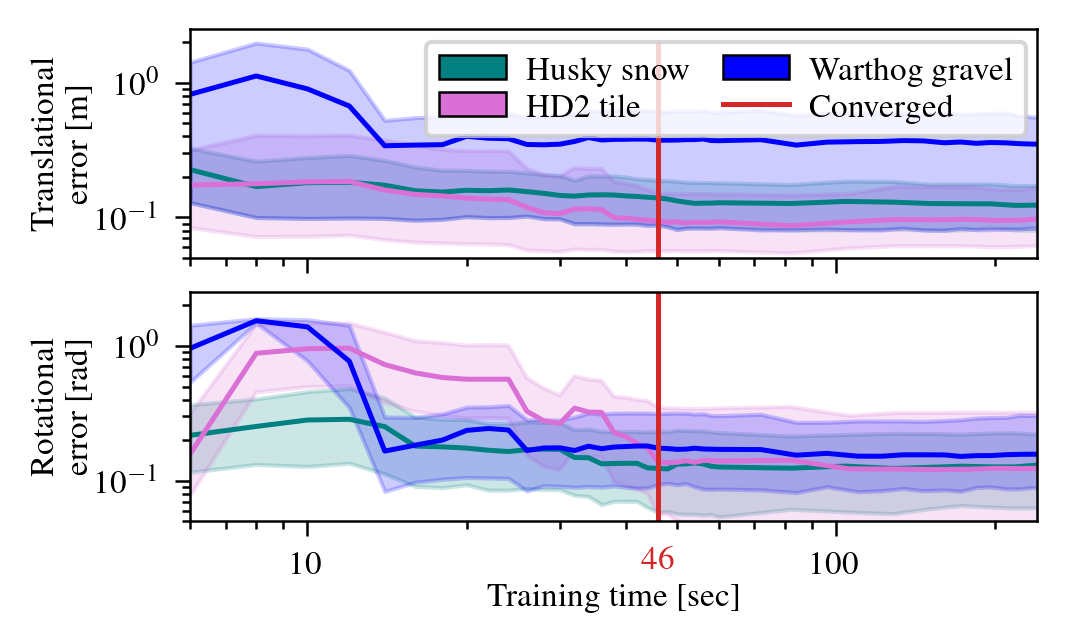

In [132]:
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Ellipse, Rectangle, Patch

from matplotlib.lines import Line2D

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.close('all')

width  = 3.402
height = width / 1.7

fig, axs = plt.subplots(2, 1, dpi=300, gridspec_kw={'hspace': 0.15, 'wspace': 0.0}, sharex=True)
fig.set_size_inches(width, height)
fig.subplots_adjust(left=.165, bottom=0.16, right=.995, top=.98)

myWidth = 0.6
plot_line_width = 1.2

for axis in ['top','bottom','left','right']:
    axs[0].spines[axis].set_linewidth(myWidth)
    axs[1].spines[axis].set_linewidth(myWidth)

axs[0].tick_params(width=myWidth)
axs[1].tick_params(width=myWidth)

husky_snow_color = 'teal'
marmotte_tile_color = 'orchid'
warthog_wheels_color = 'blue'

quartile_alpha = 0.2

translational_ymin = 0
translational_ymax = 2.0
rotational_ymin = 0
rotational_ymax = 2.0

axs[0].plot(x_linspace_husky_snow_seconds, translational_slip_prediction_medians_husky_snow, color=husky_snow_color, linewidth=plot_line_width)
axs[0].fill_between(x_linspace_husky_snow_seconds, translational_slip_prediction_3q_husky_snow, translational_slip_prediction_1q_husky_snow, color=husky_snow_color, alpha=quartile_alpha)
axs[0].plot(x_linspace_marmotte_tile_seconds, translational_slip_prediction_medians_marmotte_tile, color=marmotte_tile_color, linewidth=plot_line_width)
axs[0].fill_between(x_linspace_marmotte_tile_seconds, translational_slip_prediction_3q_marmotte_tile, translational_slip_prediction_1q_marmotte_tile, color=marmotte_tile_color, alpha=quartile_alpha)
axs[0].plot(x_linspace_warthog_wheels_gravel_seconds, translational_slip_prediction_medians_warthog_wheels_gravel, color=warthog_wheels_color, linewidth=plot_line_width)
axs[0].fill_between(x_linspace_warthog_wheels_gravel_seconds, translational_slip_prediction_3q_warthog_wheels_gravel, translational_slip_prediction_1q_husky_snow, color=warthog_wheels_color, alpha=quartile_alpha)

axs[1].plot(x_linspace_husky_snow_seconds, rotational_slip_prediction_medians_husky_snow, color=husky_snow_color, linewidth=plot_line_width)
axs[1].fill_between(x_linspace_husky_snow_seconds, rotational_slip_prediction_3q_husky_snow, rotational_slip_prediction_1q_husky_snow, color=husky_snow_color, alpha=quartile_alpha)
axs[1].plot(x_linspace_marmotte_tile_seconds, rotational_slip_prediction_medians_marmotte_tile, color=marmotte_tile_color, linewidth=plot_line_width)
axs[1].fill_between(x_linspace_marmotte_tile_seconds, rotational_slip_prediction_3q_marmotte_tile, rotational_slip_prediction_1q_marmotte_tile, color=marmotte_tile_color, alpha=quartile_alpha)
axs[1].plot(x_linspace_warthog_wheels_gravel_seconds, rotational_slip_prediction_medians_warthog_wheels_gravel, color=warthog_wheels_color, linewidth=plot_line_width)
axs[1].fill_between(x_linspace_warthog_wheels_gravel_seconds, rotational_slip_prediction_3q_warthog_wheels_gravel, rotational_slip_prediction_1q_warthog_wheels_gravel, color=warthog_wheels_color, alpha=quartile_alpha)

critical_num_windows = 23 * 2
critical_num_color = 'C3'
axs[0].vlines(critical_num_windows, translational_ymin, translational_ymax, color=critical_num_color, linewidth=plot_line_width)
axs[1].vlines(critical_num_windows, rotational_ymin, 2.5, color=critical_num_color, linewidth=plot_line_width)

# axs[0].set_ylim(np.log10(translational_ymin), np.log10(translational_ymax))
axs[0].set_ylim(0.05, 2.5)
axs[1].set_ylim(0.05, 2.5)
# axs[1].set_ylim(rotational_ymin, rotational_ymax)
axs[0].set_ylabel(r'Translational' + '\n' + r'error [m]', labelpad=0.5)
axs[1].set_xlabel(r'Training time [sec]', labelpad=0.5)
axs[1].set_ylabel(r'Rotational' + '\n' + r'error [rad]', labelpad=0.5)


axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_yscale('log')

# axs[0].set_yticks([0, 1, 2])
# axs[1].set_yticks([0, 1, 2])

axs[0].set_xlim(3*2, 120*2)
axs[1].set_xticks([10, 100], labels=[r'$10$', r'$100$'])
# axs[1].text(critical_num_windows, -0.4, str(critical_num_windows), ha='center', va='center', fontsize=8, color=critical_num_color)
axs[1].text(46, 0.033, str(critical_num_windows), ha='center', va='top', fontsize=8, color=critical_num_color)


# legend
legend_elements = [Patch(facecolor=husky_snow_color, linewidth=myWidth, label=r'Husky snow', linestyle='solid', edgecolor='k'),
                   Patch(facecolor=marmotte_tile_color, linewidth=myWidth, label=r'HD2 tile', linestyle='solid', edgecolor='k'),
                   Patch(facecolor=warthog_wheels_color, linewidth=myWidth, label=r'Warthog gravel', linestyle='solid', edgecolor='k'),
                   Line2D([0], [0], color=critical_num_color, linewidth=plot_line_width, label=r'Converged', linestyle='solid')]

fig.legend(handles=legend_elements, loc='center', ncol=2, bbox_to_anchor=(0.69,0.88), labelspacing=0.2, handletextpad=0.6, columnspacing=1, handleheight=0.7, handlelength=2)

plt.savefig('figs/training_windows_vs_accuracy_cg_v1.pdf', dpi=500)
plt.savefig('figs/training_windows_vs_accuracy_cg_v1.jpg', dpi=500)



/tmp/ipykernel_167550/2567668769.py:69: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[0].cla()
/tmp/ipykernel_167550/2567668769.py:69: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[0].cla()
/tmp/ipykernel_167550/2567668769.py:69: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[0].cla()
/tmp/ipykernel_167550/2567668769.py:69: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[0].cla()
/tmp/ipykernel_167550/2567668769.py:69: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[0].cla()
/tmp/ipykernel_167550/2567668769.py:69: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[0].cla()
/tmp/ipykernel_167550/2567668769.p

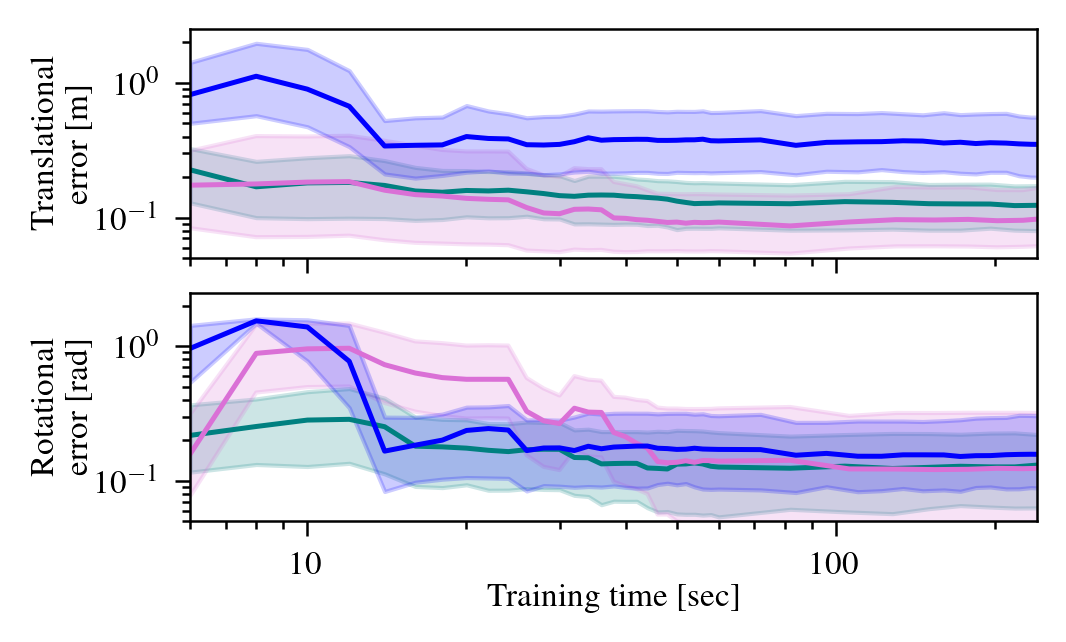

In [130]:
import matplotlib.animation as animation

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Ellipse, Rectangle, Patch

from matplotlib.lines import Line2D

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.close('all')

width  = 3.402
height = width / 1.7

fig, axs = plt.subplots(2, 1, dpi=300, gridspec_kw={'hspace': 0.15, 'wspace': 0.0}, sharex=True)
fig.set_size_inches(width, height)
fig.subplots_adjust(left=.165, bottom=0.16, right=.995, top=.98)

myWidth = 0.6
plot_line_width = 1.2

for axis in ['top','bottom','left','right']:
    axs[0].spines[axis].set_linewidth(myWidth)
    axs[1].spines[axis].set_linewidth(myWidth)

axs[0].tick_params(width=myWidth)
axs[1].tick_params(width=myWidth)

husky_snow_color = 'teal'
marmotte_tile_color = 'orchid'
warthog_wheels_color = 'blue'

quartile_alpha = 0.2

translational_ymin = 0
translational_ymax = 2.0
rotational_ymin = 0
rotational_ymax = 2.0

husky_plot = axs[0].plot(x_linspace_husky_snow_seconds[:], translational_slip_prediction_medians_husky_snow[:], color=husky_snow_color, linewidth=plot_line_width)
husky_fill = axs[0].fill_between(x_linspace_husky_snow_seconds[:], translational_slip_prediction_3q_husky_snow[:], translational_slip_prediction_1q_husky_snow[:], color=husky_snow_color, alpha=quartile_alpha)
# husky_fill = axs[0].fill_between(0, 0, 0, color=husky_snow_color, alpha=quartile_alpha)
marmotte_plot = axs[0].plot(x_linspace_marmotte_tile_seconds[0], translational_slip_prediction_medians_marmotte_tile[0], color=marmotte_tile_color, linewidth=plot_line_width)
# marmotte_fill = axs[0].fill_between(x_linspace_marmotte_tile_seconds[0], translational_slip_prediction_3q_marmotte_tile[0], translational_slip_prediction_1q_marmotte_tile[0], color=marmotte_tile_color, alpha=quartile_alpha)
warthog_plot = axs[0].plot(x_linspace_warthog_wheels_gravel_seconds[0], translational_slip_prediction_medians_warthog_wheels_gravel[0], color=warthog_wheels_color, linewidth=plot_line_width)
warthog_fill = axs[0].fill_between([x_linspace_warthog_wheels_gravel_seconds[0]], translational_slip_prediction_3q_warthog_wheels_gravel[0], translational_slip_prediction_1q_husky_snow[0], color=warthog_wheels_color, alpha=quartile_alpha)
# warthog_fill = axs[0].fill_between(0, 0, color=warthog_wheels_color, alpha=quartile_alpha)

axs[1].plot(x_linspace_husky_snow_seconds, rotational_slip_prediction_medians_husky_snow, color=husky_snow_color, linewidth=plot_line_width)
axs[1].fill_between(x_linspace_husky_snow_seconds, rotational_slip_prediction_3q_husky_snow, rotational_slip_prediction_1q_husky_snow, color=husky_snow_color, alpha=quartile_alpha)
# axs[1].plot(x_linspace_marmotte_tile_seconds, rotational_slip_prediction_medians_marmotte_tile, color=marmotte_tile_color, linewidth=plot_line_width)
# axs[1].fill_between(x_linspace_marmotte_tile_seconds, rotational_slip_prediction_3q_marmotte_tile, rotational_slip_prediction_1q_marmotte_tile, color=marmotte_tile_color, alpha=quartile_alpha)
# axs[1].plot(x_linspace_warthog_wheels_gravel_seconds, rotational_slip_prediction_medians_warthog_wheels_gravel, color=warthog_wheels_color, linewidth=plot_line_width)
# axs[1].fill_between(x_linspace_warthog_wheels_gravel_seconds, rotational_slip_prediction_3q_warthog_wheels_gravel, rotational_slip_prediction_1q_warthog_wheels_gravel, color=warthog_wheels_color, alpha=quartile_alpha)



# plt.savefig('figs/training_windows_vs_accuracy_cg_v1.pdf', dpi=500)
# plt.savefig('figs/training_windows_vs_accuracy_cg_v1.jpg', dpi=500)

def update(frame):
    axs[0].cla()
    axs[1].cla()
    husky_plot = axs[0].plot(x_linspace_husky_snow_seconds[:], translational_slip_prediction_medians_husky_snow[:], color=husky_snow_color, linewidth=plot_line_width)
    husky_fill = axs[0].fill_between(x_linspace_husky_snow_seconds[:], translational_slip_prediction_3q_husky_snow[:], translational_slip_prediction_1q_husky_snow[:], color=husky_snow_color, alpha=quartile_alpha)
    axs[1].plot(x_linspace_husky_snow_seconds[:], rotational_slip_prediction_medians_husky_snow[:], color=husky_snow_color, linewidth=plot_line_width)
    axs[1].fill_between(x_linspace_husky_snow_seconds[:], rotational_slip_prediction_3q_husky_snow[:], rotational_slip_prediction_1q_husky_snow[:], color=husky_snow_color, alpha=quartile_alpha)
    
    marmotte_plot = axs[0].plot(x_linspace_marmotte_tile_seconds[:], translational_slip_prediction_medians_marmotte_tile[:], color=marmotte_tile_color, linewidth=plot_line_width)
    marmotte_fill = axs[0].fill_between(x_linspace_marmotte_tile_seconds[:], translational_slip_prediction_3q_marmotte_tile[:], translational_slip_prediction_1q_marmotte_tile[:], color=marmotte_tile_color, alpha=quartile_alpha)
    axs[1].plot(x_linspace_marmotte_tile_seconds[:], rotational_slip_prediction_medians_marmotte_tile[:], color=marmotte_tile_color, linewidth=plot_line_width)
    axs[1].fill_between(x_linspace_marmotte_tile_seconds[:], rotational_slip_prediction_3q_marmotte_tile[:], rotational_slip_prediction_1q_marmotte_tile[:], color=marmotte_tile_color, alpha=quartile_alpha)
    # 
    warthog_plot = axs[0].plot(x_linspace_warthog_wheels_gravel_seconds[:frame], translational_slip_prediction_medians_warthog_wheels_gravel[:frame], color=warthog_wheels_color, linewidth=plot_line_width)
    warthog_fill = axs[0].fill_between(x_linspace_warthog_wheels_gravel_seconds[:frame], translational_slip_prediction_3q_warthog_wheels_gravel[:frame], translational_slip_prediction_1q_warthog_wheels_gravel[:frame], color=warthog_wheels_color, alpha=quartile_alpha)
    axs[1].plot(x_linspace_warthog_wheels_gravel_seconds[:frame], rotational_slip_prediction_medians_warthog_wheels_gravel[:frame], color=warthog_wheels_color, linewidth=plot_line_width)
    axs[1].fill_between(x_linspace_warthog_wheels_gravel_seconds[:frame], rotational_slip_prediction_3q_warthog_wheels_gravel[:frame], rotational_slip_prediction_1q_warthog_wheels_gravel[:frame], color=warthog_wheels_color, alpha=quartile_alpha)

    # return (warthog_plot[0], warthog_fill)
    
    
    # axs[0].set_ylim(np.log10(translational_ymin), np.log10(translational_ymax))
    axs[0].set_ylim(0.05, 2.5)
    axs[1].set_ylim(0.05, 2.5)
    # axs[1].set_ylim(rotational_ymin, rotational_ymax)
    axs[0].set_ylabel(r'Translational' + '\n' + r'error [m]', labelpad=0.5)
    axs[1].set_xlabel(r'Training time [sec]', labelpad=0.5)
    axs[1].set_ylabel(r'Rotational' + '\n' + r'error [rad]', labelpad=0.5)
    
    
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    
    # axs[0].set_yticks([0, 1, 2])
    # axs[1].set_yticks([0, 1, 2])
    
    axs[0].set_xlim(3*2, 120*2)
    axs[1].set_xticks([10, 100], labels=[r'$10$', r'$100$'])
    # axs[1].text(critical_num_windows, -0.4, str(critical_num_windows), ha='center', va='center', fontsize=8, color=critical_num_color)
    # axs[1].text(46, 0.033, str(critical_num_windows), ha='center', va='top', fontsize=8, color=critical_num_color)


ani = animation.FuncAnimation(fig=fig, func=update, frames=100, interval=30)
# ani.save('anim/training_time_husky.mp4', fps=20)
# ani.save('anim/training_time_husky_marmotte.mp4', fps=20)
ani.save('anim/training_time_husky_marmotte_warthog.mp4', fps=20)



In [ ]:
x_linspace = np.logspace(0, )